In [4]:
from random import randint
import matplotlib.pyplot as plt
import torch
from src.vae.mnist_vae import ConditionalVae
from torchvision import transforms
from src.image_classifier.exq_net_v1 import ExquisiteNetV1
import torchvision
import torch.utils.data

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# binarize the data
apply_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.round(x))
])

training_data = torchvision.datasets.MNIST(root='../../data/MNIST_train', train=True, download=True, transform=apply_transform)
testing_data = torchvision.datasets.MNIST(root='../../data/MNIST_test', train=False, download=True, transform=apply_transform)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
  

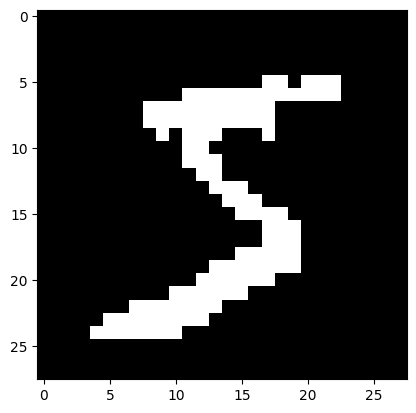

In [6]:
# Train a VAE using normalized MNIST
plt.imshow(training_data[0][0][0], cmap='gray')

print(training_data[0][0][0])

# Use VAE to generate some data
cvae = ConditionalVae(dim_encoding=3).to('cuda:0')

# try with model sigma
vae_model, vae_loss_li, kl_loss_li, reg_loss_li = cvae.train_model(
    training_data=training_data,
    batch_size=32,
    epochs=10,
    learning_rate=0.001
)

In [7]:
# generate images for training on classifier
data_count = 60000

generated_dataset = []
uniform_digits = [randint(0, 9) for _ in range(data_count)]
for i in uniform_digits:
    generated_image = cvae.generate_data(n_samples=1, target_label=i).squeeze(1)
    multiplier = 1.0/generated_image.max().item()
    transformed_image = torch.round(generated_image*multiplier)
    generated_dataset.append((transformed_image, i))
    
to_be_zipped = []
for image_ind in range(data_count):
    to_be_zipped.append(
        (generated_dataset[image_ind][0], generated_dataset[image_ind][1])
    )
initial_dataset = torch.tensor([])
binarized_training_data = torch.utils.data.ConcatDataset([initial_dataset, to_be_zipped])

In [8]:
batch_size = 64
epoch = 5
learning_rate = 0.01

classifier = ExquisiteNetV1(class_num=10, img_channels=1)
classifier.to(device)
classifier.train_model(binarized_training_data, testing_data, batch_size=batch_size, learning_rate=learning_rate, epochs=epoch)

/home/neo/projects/Federated-Learning-PyTorch/venv/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/neo/projects/Federated-Learning-PyTorch/venv/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch done:  1
Training loss:  0.004759947769343853
Testing loss:  -0.9684890527634104
Epoch done:  2
Training loss:  0.0036190187092870474
Testing loss:  -1.0680902140915016
Epoch done:  3
Training loss:  0.0017668011132627726
Testing loss:  -1.1209823834668293
Epoch done:  4
Training loss:  0.0009785881265997887
Testing loss:  -1.1648557281038565
Epoch done:  5
Training loss:  0.0011354731395840645
Testing loss:  -1.1910375208611703


In [9]:
# test on real data
accuracy, loss, f1_macro, f1_micro = classifier.test_inference(testing_data, batch_size)

print(accuracy)
print(loss)
print(f1_macro)
print(f1_micro)

0.3092
-1.1964832832858834
0.29369261451387074
0.3092
